In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns;
sns.set()

### Motivating GMM: Weaknesses of k-Means

In [2]:
from sklearn.datasets import make_blobs
X,y_true=make_blobs(n_samples=300,centers=4,
               cluster_std=0.60, random_state=0)
X=X[:,::-1]#flip axes for better plotting

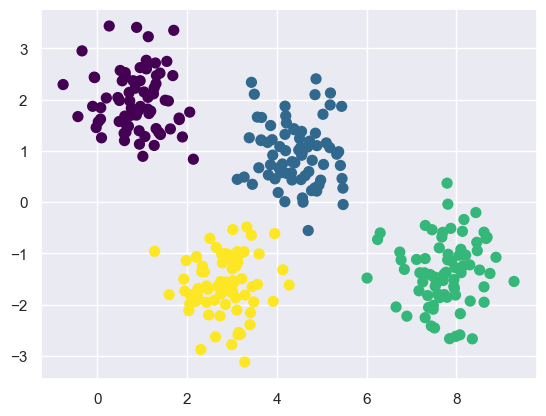

In [3]:
#plot the data with k-means labels
from sklearn.cluster import KMeans
kmeans=KMeans(4,random_state=0)
labels=kmeans.fit(X).predict(X)
plt.scatter(X[:,0],X[:,1], c=labels, s=50, cmap='viridis');

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans,X,n_clusters=4,rseed=0,ax=None):
    labels=kmeans.fit_predict(X)
    
    #plot the input data
    ax=ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:,0],X[:,1],c=labels,s=50,cmap='viridis', zorder=2)
    
    #plot the representation of the k-means model
    centers=kmeans.cluster_centers_
    radii=[cdist(X[labels==i],[center]).max()
          for i, center in enumerate(centers)]
    for c,r in zip(centers,radii):
        ax.add_patch(plt.Circle(c,r,fc='#CCCCCC',lw=3, alpha=0.5, zorder=1))
        

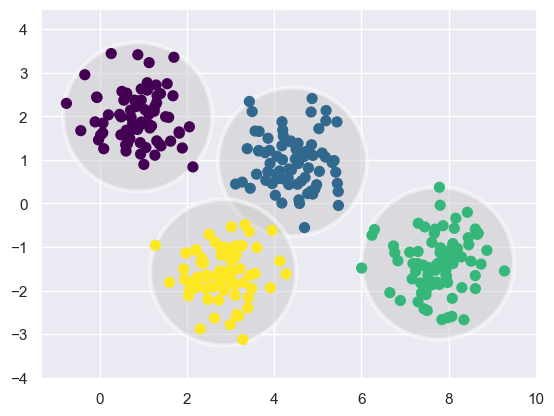

In [5]:
kmeans=KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans,X)

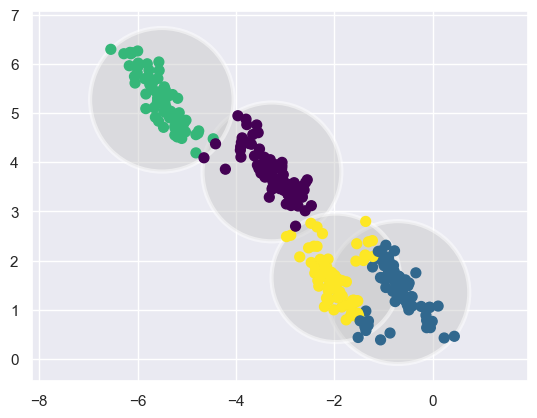

In [6]:
rng=np.random.RandomState(13)
X_stretched=np.dot(X,rng.randn(2,2))

kmeans=KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans,X_stretched)

### Generalizing E–M: Gaussian Mixture Models

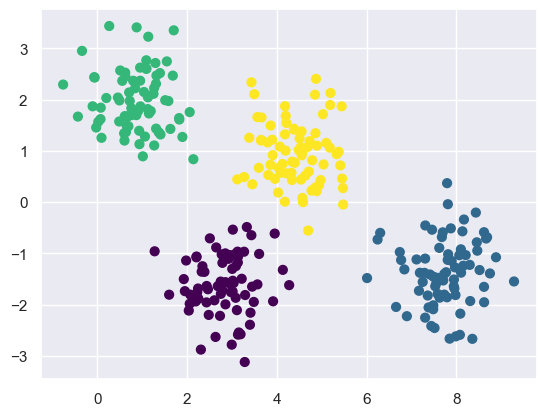

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm=GMM(n_components=4).fit(X)
labels=gmm.predict(X)
plt.scatter(X[:,0],X[:,1],c=labels,s=40,cmap='viridis');

In [8]:
probs=gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.002 0.    0.972 0.026]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.999 0.001]]


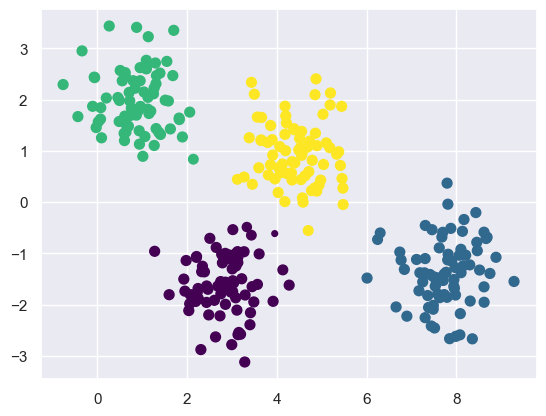

In [9]:
#visualize this uncertainity
size=50*probs.max(1)**2 #square emphasizes differences
plt.scatter(X[:,0],X[:,1],c=labels, cmap='viridis', s=size);

In [10]:
#create a function that will help us visualize the locations and shapes of the GMM
#clusters by drawing ellipses based on the gmm output:

from matplotlib.patches import Ellipse

def draw_ellipse(position,covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax=ax or plt.gca()
    
    #convert covariance to principal axes
    if covariance.shape==(2,2):
        U,s,Vt=np.linalg.svd(covariance)
        angle=np.degrees(np.arctan2(U[1,0],U[0,0]))
        width,height=2*np.sqrt(s)
    else:
        angle=0
        width, height=2*np.sqrt(covariance)
        
    #Draw the ellipse
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig*width, nsig*height,
                            angle, **kwargs))
        
def plot_gmm(gmm,X,label=True, ax=None):
    ax=ax or plt.gca()
    labels=gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:,0],X[:,1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:,0],X[:,1],s=40,zorder=2)
    ax.axis('equal')
    
    w_factor=0.2/gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


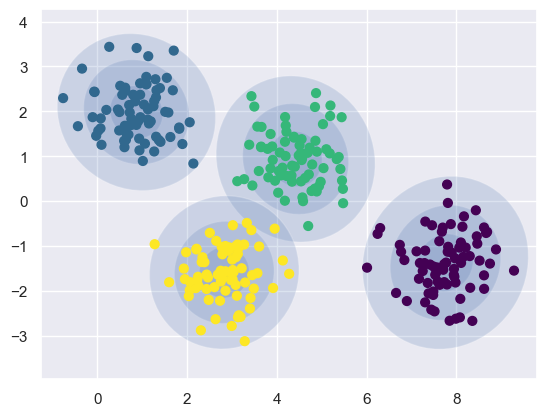

In [11]:
#use the funtion to look at the 4-component GMM for the initial data
gmm=GMM(n_components=4, random_state=42)
plot_gmm(gmm,X)

Similarly, you can use the GMM approach to fit the stretched dataset; allowing for a
full covariance, the model will fit even very oblong, stretched-out clusters

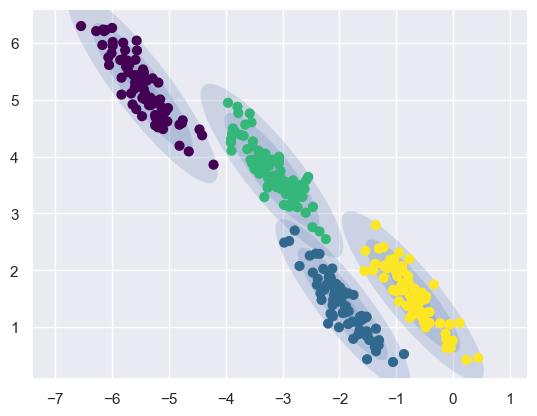

In [12]:
gmm=GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### GMM as Density Estimation

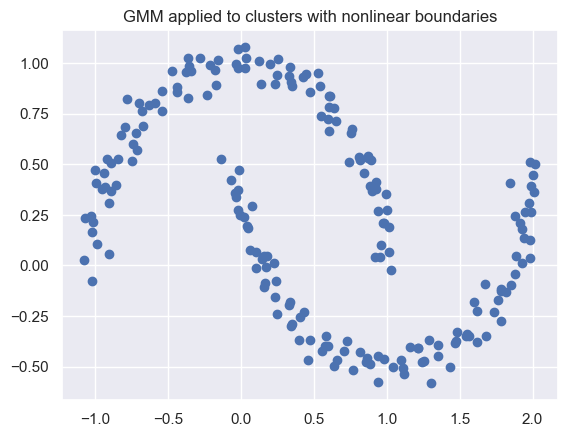

In [13]:
from sklearn.datasets import make_moons
Xmoon,ymoon=make_moons(n_samples=200,noise=.05, random_state=0)
plt.title('GMM applied to clusters with nonlinear boundaries')
plt.scatter(Xmoon[:,0],Xmoon[:,1]);

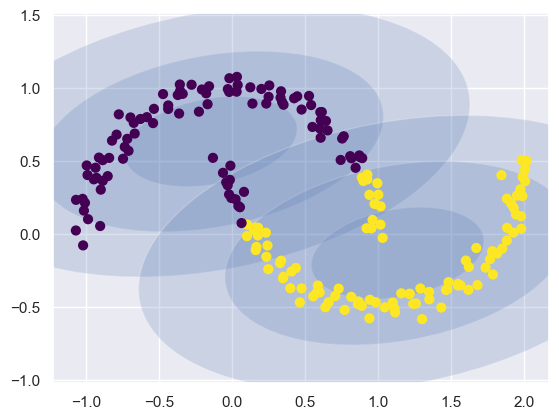

In [14]:
#try to fit moons into a 2-component GMM viewed as clustering model
gmm2=GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2,Xmoon)

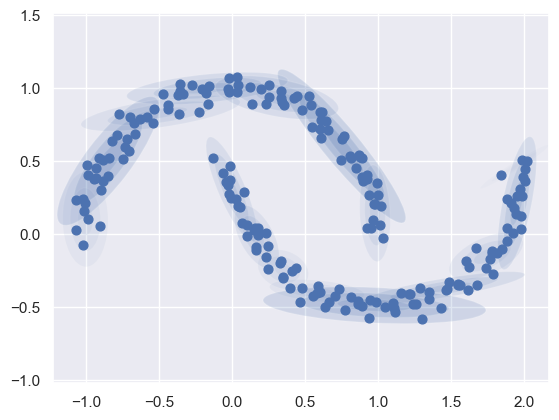

In [15]:
#try using more number of components and ignore the cluster labels, makes sense?
gmm16=GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16,Xmoon, label=False)

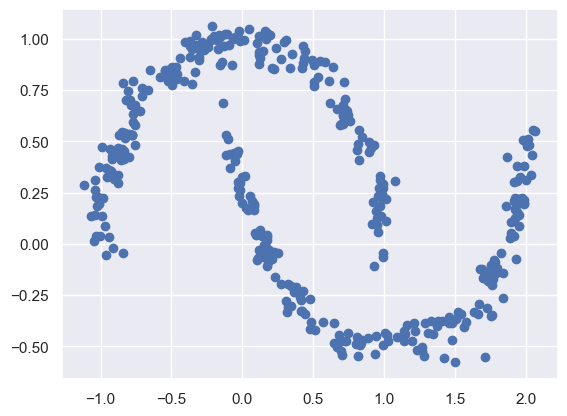

In [39]:
Xnew, ynew=gmm16.sample(400)
plt.scatter(Xnew[:,0],Xnew[:,1]);

#### How many components?

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


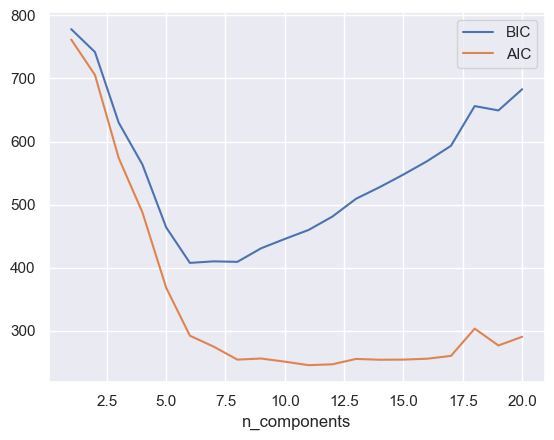

In [17]:
n_components=np.arange(1,21)
models=[GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
       for n in n_components]

plt.plot(n_components,[m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components,[m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

### Example: GMM for Generating New Data

In [18]:
from sklearn.datasets import load_digits
digits=load_digits()
digits.data.shape

(1797, 64)

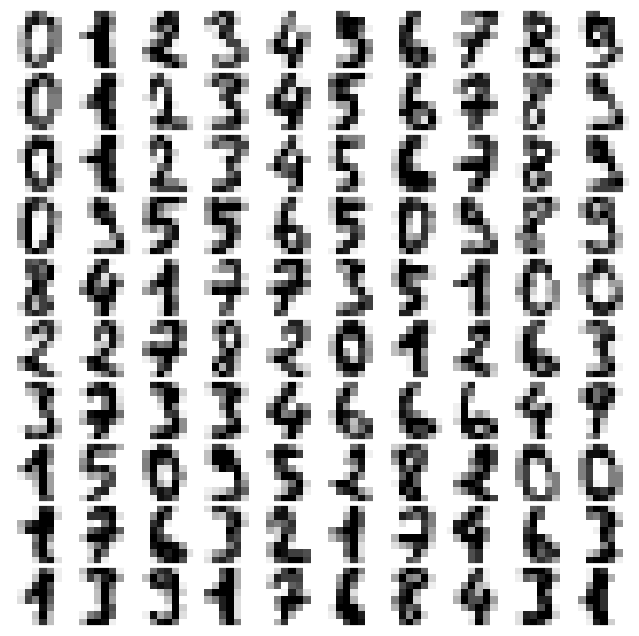

In [19]:
#plot some of this digits
def plot_digits(data):
    fig,ax=plt.subplots(10,10, figsize=(8,8),
                       subplot_kw=dict(xticks=[],yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im=axi.imshow(data[i].reshape(8,8), cmap='binary')
        im.set_clim(0,16)
plot_digits(digits.data)

In [20]:
#use dimentionaity reduction
from sklearn.decomposition import PCA
pca=PCA(0.99,whiten=True)
data=pca.fit_transform(digits.data)
data.shape

(1797, 41)

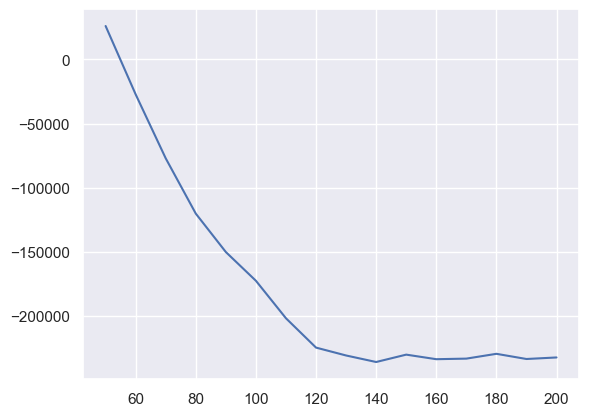

In [21]:
#use AIC to get a gauge for the number of GMM components to use
n_components=np.arange(50,210,10)
models=[GMM(n,covariance_type='full', random_state=0)
       for n in n_components]
aics=[model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [26]:
gmm=GMM(n_components=110,covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [44]:
data_new=gmm.sample(100)

In [42]:
#use the inverse transform of the PCA object to construct new digits
digits_new=pca.inverse_transform(data_new)
plot_digits(digits_new)

ValueError: could not broadcast input array from shape (100,41) into shape (100,)